Trabajo Práctico N° 2

# INSTALACIÓN E IMPORTACIÓN DE LIBRERÍAS

In [1]:
!pip install geopandas
!pip install pygeos
!apt install gdal-bin python-gdal python3-gdal
!apt install python3-rtree
!pip install contextily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.4 MB/s 
     |████████████████████████████████| 6.3 MB 40.1 MB/s 
     |████████████████████████████████| 16.7 MB 387 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 4.6 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import statistics as stat
import shapely.wkt
import matplotlib.pyplot as plt
import descartes
import seaborn as sns
import regex as re
import rtree
import pygeos
import contextily as ctx
import seaborn as sns
import matplotlib as mpl

import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn import linear_model
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import random






# GLOSARIO

* data_raw: es el dataset que obtuvimos como resultado del TP1.

* deptos_caba_raw: es el conjunto de datos obtenido una vez filtradas las observaciones según el tipo de propiedad a analizar (departamentos) y su ubicación (CABA) 

* deptos_caba_clean: es el conjunto de datos correspondientes a deparamentos en CABA obtenido una vez eliminados los registros duplicados y aquellos con datos faltantes en alguna variable de interés 

* geo_deptos_caba: es el dataset espacial que incluye las nuevas variables de localización creadas en base a los cruces realizados con otros datasets consultados

* deptos_caba_final: es el conjunto final de datos a modelar

# SELECCIÓN DE LOS DATOS A MODELAR

En este apartado realizaremos el proceso de selección del conjunto de datos que vamos a modelar. En la primera sección nos concentraremos en operaciones sobre las filas del dataframe, a fin de seleccionar las observaciones que vamos a considerar, mientras que en la segunda, trabajaremos sobre las columnas, con el objetivo de seleccionar las variables que vamos a utilizar en el proceso de modelización de los datos.

## Importación de data set

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
url = '/content/drive/MyDrive/DH - DESAFIOS GRUPO 4/properati_clean.csv'
data_raw = pd.read_csv(url)

Como puede verse el conjunto de datos a utilizar en el trabajo ha sido importado como un DataFrame de Pandas con 121.220 observaciones (filas) que registran datos de inmuebles organizados en 28 variables (columnas), tal como resulta del desarrollo del trabajo anterior:

In [5]:
display(data_raw.shape)
display(data_raw.info())

(121220, 26)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  121220 non-null  int64  
 1   operation                   121220 non-null  object 
 2   property_type               121220 non-null  object 
 3   place_name                  121220 non-null  object 
 4   place_with_parent_names     121220 non-null  object 
 5   country_name                121220 non-null  object 
 6   state_name                  121220 non-null  object 
 7   geonames_id                 102503 non-null  float64
 8   price                       100812 non-null  float64
 9   currency                    100811 non-null  object 
 10  price_aprox_local_currency  100810 non-null  float64
 11  price_aprox_usd             100810 non-null  float64
 12  surface_total_in_m2         83199 non-null   float64
 13  surface_covere

None

## Selección de observaciones [filas]

Comenzamos el proceso de selección de datos a modelar por las filas de nuestro dataset. Para este trabajo hemos definido quedarnos solamente con las observaciones correspondientes a departamentos en la Ciudad Autónoma de Buenos Aires, eliminando los registros duplicados y aquellos sin datos en alguno de los campos de nuestras variables de interés. 

### Filtro de registros por tipo de propiedad y ubicación

Para empezar, filtramos nuestro conjunto de datos según el tipo de propiedad y su ubicación, a fin de quedarnos solamente con los registros de departamentos en CABA, que son los que vamos a utilizar para desarrollar nuestros modelos:

In [6]:
mask_apartment_caba = (data_raw["property_type"] =='apartment') & (data_raw["state_name"] =='Ciudad Autónoma de Buenos Aires')
deptos_caba_raw = data_raw.loc[mask_apartment_caba,:]
print('Cantidad registros en el data set original:', data_raw.shape[0])
print('Cantidad registros en el data set filtrado por tipo de propiedad y ubicación:', deptos_caba_raw.shape[0])
print('La cantidad de registros seleccionados representa aproximadamente el ', round((deptos_caba_raw.shape[0] * 100 / data_raw.shape[0]),1), 
      ' % de las observaciones totales', sep='')

Cantidad registros en el data set original: 121220
Cantidad registros en el data set filtrado por tipo de propiedad y ubicación: 27037
La cantidad de registros seleccionados representa aproximadamente el 22.3 % de las observaciones totales


In [7]:
deptos_caba_raw.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'price', 'currency', 'price_aprox_local_currency', 'price_aprox_usd',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'price_per_m2', 'floor', 'rooms', 'expenses', 'properati_url',
       'description', 'title', 'image_thumbnail', 'region', 'x', 'y'],
      dtype='object')

### Eliminación de regristros duplicados

Para eliminar los registros duplicados utilizamos como referencia las columnas 'description' y 'price'. Asumimos que si los valores de estas dos variables coinciden para más de una observación, lo mas probable es que se trate de la misma propiedad:

In [8]:
deptos_caba_sinduplicados = deptos_caba_raw.drop_duplicates(subset = ['description','price'], keep = 'first' )

print('Cantidad registros en el data set original:', data_raw.shape[0])
print('Cantidad registros en el data set filtrado por tipo de propiedad y ubicación:', deptos_caba_raw.shape[0])
print('Cantidad registros en el data set sin duplicados:', deptos_caba_sinduplicados.shape[0])
print('La cantidad de registros eliminados es de ', deptos_caba_raw.shape[0] - deptos_caba_sinduplicados.shape[0], 
      ', que representa aproximadamente el ', round(((deptos_caba_raw.shape[0] - deptos_caba_sinduplicados.shape[0]) 
      * 100 / deptos_caba_raw.shape[0]),1), ' % de nuestras observaciones de interés', sep='')

Cantidad registros en el data set original: 121220
Cantidad registros en el data set filtrado por tipo de propiedad y ubicación: 27037
Cantidad registros en el data set sin duplicados: 24273
La cantidad de registros eliminados es de 2764, que representa aproximadamente el 10.2 % de nuestras observaciones de interés


### Eliminación de registros con campos sin datos

Seguidamente, eliminamos las observaciones sin datos en los campos correspondientes a la variable a predecir o *target* (precio por metro cuadrado) y aquellas con datos faltantes en alguna de las variables que vamos a utilizar para el desarrollo de los modelos (variables predictoras o *features*).

In [9]:
deptos_caba_sinduplicados.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'price', 'currency', 'price_aprox_local_currency', 'price_aprox_usd',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'price_per_m2', 'floor', 'rooms', 'expenses', 'properati_url',
       'description', 'title', 'image_thumbnail', 'region', 'x', 'y'],
      dtype='object')

In [10]:
deptos_caba_sinmissing = deptos_caba_sinduplicados.dropna(subset=['price_usd_per_m2', 'description', 
                                                                  'x', 'y', 'place_name',
                                                                  'surface_total_in_m2', 'surface_covered_in_m2', 'rooms'])
print('Cantidad registros en el data set original:', data_raw.shape[0])
print('Cantidad registros en el data set filtrado por tipo de propiedad y ubicación:', deptos_caba_raw.shape[0])
print('Cantidad registros en el data set sin duplicados:', deptos_caba_sinduplicados.shape[0])
print('Cantidad registros en el data set sin missing:', deptos_caba_sinmissing.shape[0])
print('La cantidad de registros eliminados es de ', deptos_caba_sinduplicados.shape[0] - deptos_caba_sinmissing.shape[0], 
      ', que representa aproximadamente el ', round(((deptos_caba_sinduplicados.shape[0] - deptos_caba_sinmissing.shape[0]) 
      * 100 / deptos_caba_raw.shape[0]),1), ' % de nuestras observaciones de interés', sep='')

Cantidad registros en el data set original: 121220
Cantidad registros en el data set filtrado por tipo de propiedad y ubicación: 27037
Cantidad registros en el data set sin duplicados: 24273
Cantidad registros en el data set sin missing: 11860
La cantidad de registros eliminados es de 12413, que representa aproximadamente el 45.9 % de nuestras observaciones de interés


### Eliminacion de registros con valores atipicos muy extremos

Finalmente, eliminamos los registros con valores atípicos muy extremos que podrían sesgar nuestro modelo. Como habíamos visto en el trabajo anterior, el dataset original contaba, sobre todo a la derecha de la curva de distribución de frecuencia, con outliers muy alejados de las medidas de tendencia central, muy probablemente atribuibles a errores de carga.

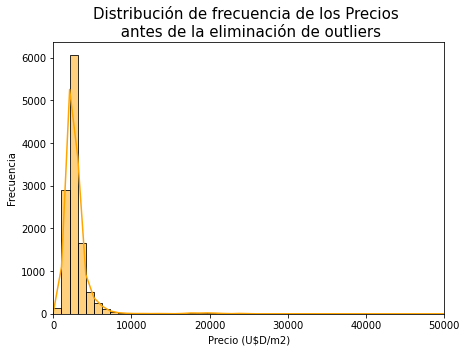

In [11]:
fig = plt.figure(figsize=(7,5))
ax = plt.axes()
ax.set_xlim(0, 50000)

sns.histplot(data=deptos_caba_sinmissing, x=deptos_caba_sinmissing['price_usd_per_m2'], color='orange', bins=200, kde=True)

plt.xlabel('Precio (U$D/m2)',size=10);
plt.ylabel('Frecuencia', size=10)
plt.title('Distribución de frecuencia de los Precios \n antes de la eliminación de outliers', size=15)

plt.show()

In [12]:
# Se aplica un "cut" para poder eliminar aquellos valores extremos

valores_extremos_bajos = 300
valores_intermedios = 4500
valores_extremos_altos = 25000

bins = [0,valores_extremos_bajos, valores_intermedios, valores_extremos_altos + 500000]
group_labels = ["VEB","VI","VEA"]

precios_m2_categorizados = pd.cut(deptos_caba_sinmissing["price_usd_per_m2"], bins, right=True, include_lowest=True, labels=group_labels) 
precios_m2_categorizados.head(10)
print (precios_m2_categorizados.value_counts())
deptos_caba_sinmissing['valores_extremos'] = precios_m2_categorizados
deptos_caba_sinmissing['valores_extremos'].value_counts()

VI     10963
VEA      874
VEB       23
Name: price_usd_per_m2, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


VI     10963
VEA      874
VEB       23
Name: valores_extremos, dtype: int64

In [13]:
deptos_caba_clean = deptos_caba_sinmissing.loc[(deptos_caba_sinmissing["valores_extremos"] =='VI')]
print('Cantidad registros en el data set original:', data_raw.shape[0])
print('Cantidad registros en el data set filtrado por tipo de propiedad y ubicación:', deptos_caba_raw.shape[0])
print('Cantidad registros en el data set sin duplicados:', deptos_caba_sinduplicados.shape[0])
print('Cantidad registros en el data set sin missing:', deptos_caba_sinmissing.shape[0])
print('Cantidad registros en el data set sin valores atípicos muy extremos:', deptos_caba_clean.shape[0])
print('La cantidad de registros eliminados es de ', deptos_caba_sinmissing.shape[0] - deptos_caba_clean.shape[0], 
      ', que representa aproximadamente el ', round(((deptos_caba_sinmissing.shape[0] - deptos_caba_clean.shape[0]) 
      * 100 / deptos_caba_raw.shape[0]),1), ' % de nuestras observaciones de interés', sep='')

Cantidad registros en el data set original: 121220
Cantidad registros en el data set filtrado por tipo de propiedad y ubicación: 27037
Cantidad registros en el data set sin duplicados: 24273
Cantidad registros en el data set sin missing: 11860
Cantidad registros en el data set sin valores atípicos muy extremos: 10963
La cantidad de registros eliminados es de 897, que representa aproximadamente el 3.3 % de nuestras observaciones de interés


In [14]:
deptos_caba_clean.drop(['valores_extremos'], axis=1, inplace=True)
deptos_caba_clean.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(10963, 26)

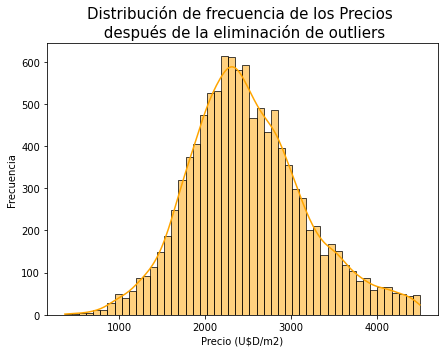

In [15]:
fig = plt.figure(figsize=(7,5))
ax = plt.axes()

sns.histplot(data=deptos_caba_clean, x=deptos_caba_clean['price_usd_per_m2'], color='orange', bins=50, kde=True)

plt.xlabel('Precio (U$D/m2)', size=10);
plt.ylabel('Frecuencia', size=10)
plt.title('Distribución de frecuencia de los Precios \n después de la eliminación de outliers', size=15)

plt.show()

## Selección y creación de variables [columnas]

Una vez seleccionado el conjunto de observaciones a utilizar, pasamos a seleccionar las variables que vamos a tomar para el proceso de modelización de los datos. Trabajamos, en primera instancia, con variables de localización y, luego, con variables relativas a las características de las propiedades con independencia de su ubicación. En ambos casos utilizamos variables ya existentes en nuestro conjunto de datos o que pueden reponerse a partir éstas, a la vez que creamos otras nuevas como producto de operaciones de cruce con otros datasets.

### Variables de localización

Nuestro dataset cuenta con tres conjuntos de variables de localización:
* barrio o localidad, provincia y país (ya que estamos trabajando solamente con datos de la ciudad de Buenos Aires, sólo la primera de ellas nos resultará relevante) 
* código de Geonames (vinculado a la anterior) 
* coordenadas geográficas

Como hemos mencionado en el trabajo anterior, puede existir inconsistencias entre estas variables para una misma observación, ya que podemos asumir que las coordenadas no se ingresan manualmente sino que es un dato generado automáticamente a partir de la ubicación del dispositivo desde el que se realiza la publicación, que puede o no coincidir con la de la propiedad publicada.

Comenzamos por analizar la distribución espacial de los precios por metro cuadrado de las propiedades según el barrio en que se encuentran publicadas. Buscamos identificar, a partir de la visualización de esta distribución, algunos patrones que nos sirvan para generar nuevas variables de localización que podamos incluir en nuestro modelos.

En este punto nos encontramos con un primer inconveniente que es que los nombres de los barrios no se encuentran correctamente categorizados en nuestro set de datos:

In [16]:
barrios = deptos_caba_clean["place_name"].unique()
display(barrios)
display(len(barrios))

array(['Mataderos', 'Belgrano', 'Palermo', 'Flores', 'Boedo',
       'Las Cañitas', 'Balvanera', 'Caballito', 'Nuñez', 'Recoleta',
       'Villa Crespo', 'Constitución', 'Colegiales', 'Villa Urquiza',
       'Barrio Norte', 'Palermo Hollywood', 'Saavedra', 'Paternal',
       'Agronomía', 'Coghlan', 'Almagro', 'Parque Centenario',
       'San Telmo', 'Monserrat', 'Boca', 'San Cristobal', 'Abasto',
       'Versalles', 'Monte Castro', 'Floresta', 'Retiro',
       'Capital Federal', 'Parque Chas', 'Barracas', 'Villa del Parque',
       'Villa Devoto', 'Palermo Soho', 'Centro / Microcentro', 'Liniers',
       'Parque Avellaneda', 'Tribunales', 'Once', 'San Nicolás',
       'Villa Pueyrredón', 'Parque Chacabuco', 'Congreso', 'Catalinas',
       'Pompeya', 'Parque Patricios', 'Velez Sarsfield', 'Palermo Chico',
       'Villa General Mitre', 'Villa Santa Rita', 'Puerto Madero',
       'Villa Luro', 'Chacarita', 'Villa Ortuzar', 'Villa Soldati',
       'Villa Lugano', 'Villa Real', 'Palermo Vie

61

Procedimos, entonces, a corregir estas categorías:

In [17]:
deptos_caba_barriosok = deptos_caba_clean.replace({'place_name': {'Palermo Soho':'Palermo', 'Palermo Hollywood': 'Palermo', 'Palermo Chico':'Palermo', 'Palermo Viejo':'Palermo', 'Las Cañitas' : 'Palermo',
                                                                 'Barrio Norte': 'Recoleta', 'Catalinas': 'Retiro', 'Abasto': 'Almagro', 'Once' : 'Balvanera', 'Pompeya' : 'Nueva Pompeya', 'Parque Centenario': 'Caballito', 
                                                                 'Tribunales' : 'San Nicolás', 'Centro / Microcentro' : 'San Nicolás', 'Congreso' : 'Monserrat', 'Villa General Mitre' : 'Villa Gral. Mitre'}})

In [18]:
deptos_caba_barriosok = deptos_caba_barriosok.loc[(deptos_caba_barriosok['place_name'] != 'Capital Federal')]
deptos_caba_barriosok.shape

(10858, 26)

In [19]:
barrios = deptos_caba_barriosok["place_name"].unique()
display(barrios)
display(len(barrios))

array(['Mataderos', 'Belgrano', 'Palermo', 'Flores', 'Boedo', 'Balvanera',
       'Caballito', 'Nuñez', 'Recoleta', 'Villa Crespo', 'Constitución',
       'Colegiales', 'Villa Urquiza', 'Saavedra', 'Paternal', 'Agronomía',
       'Coghlan', 'Almagro', 'San Telmo', 'Monserrat', 'Boca',
       'San Cristobal', 'Versalles', 'Monte Castro', 'Floresta', 'Retiro',
       'Parque Chas', 'Barracas', 'Villa del Parque', 'Villa Devoto',
       'San Nicolás', 'Liniers', 'Parque Avellaneda', 'Villa Pueyrredón',
       'Parque Chacabuco', 'Nueva Pompeya', 'Parque Patricios',
       'Velez Sarsfield', 'Villa Gral. Mitre', 'Villa Santa Rita',
       'Puerto Madero', 'Villa Luro', 'Chacarita', 'Villa Ortuzar',
       'Villa Soldati', 'Villa Lugano', 'Villa Real'], dtype=object)

47

In [20]:
deptos_caba_clean = deptos_caba_barriosok

Una vez corregidas las categorías, calculamos y graficamos los valores mínimos, máximos, la mediana y el promedio del precio en dólares por metro cuadrado para cada barrio de la ciudad: 

In [21]:
precioxbarrio = deptos_caba_clean.groupby('place_name').price_usd_per_m2
precioxbarrio = pd.DataFrame(precioxbarrio.aggregate([np.min, np.median, np.mean, np.max]).round(2))
precioxbarrio.sort_values(by='mean', ascending=False, inplace=True)
precioxbarrio.reset_index(inplace=True)
precioxbarrio.head(10)

,place_name,amin,median,mean,amax
0,Puerto Madero,2964.91,4090.85,3978.06,4450.00
1,Palermo,895.77,2979.80,3010.90,4500.00
2,Recoleta,1275.00,2918.19,2977.50,4500.00
3,Belgrano,569.95,2890.91,2919.63,4422.54
4,Nuñez,1260.62,2819.67,2855.26,4500.00
5,Retiro,1424.24,2687.50,2690.07,4363.64
6,Colegiales,638.30,2504.10,2571.23,4126.98
7,Coghlan,516.43,2560.98,2550.76,4166.67
8,Villa Urquiza,697.67,2527.26,2534.81,4437.50
9,Caballito,868.85,2436.24,2481.29,4271.74


Text(0.5, 0, 'Precio promedio (U$D/m2')

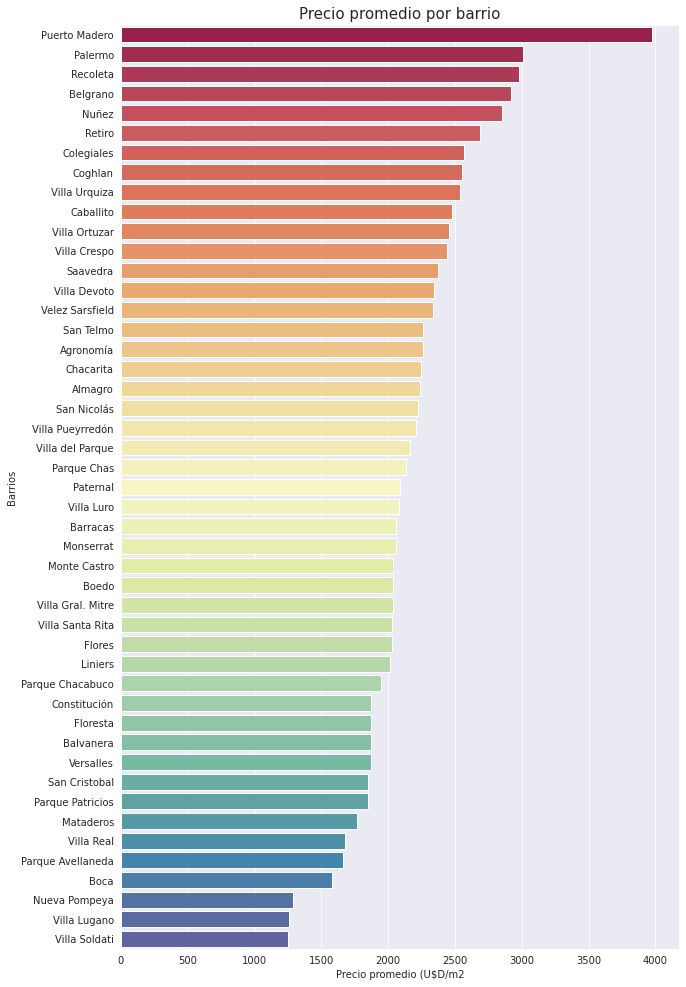

In [22]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10,17))
ax = plt.axes()

sns.barplot(x = precioxbarrio['mean'], 
            y=precioxbarrio['place_name'], palette = 'Spectral')

plt.title('Precio promedio por barrio', size=15)
plt.ylabel("Barrios", size=10)
plt.xlabel("Precio promedio (U$D/m2", size=10)

Para poder visualizar más claramente la distribución espacial de los datos, los mapeamos. Para ello, importamos un dataset con las geometrías de los polígonos de los barrios, el cual mergeamos con el dataframe en el que guardamos los precios promedio por barrio que habíamos calculado:

(48, 2)

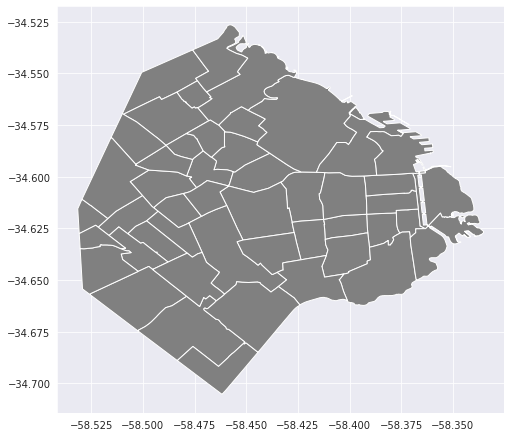

In [23]:
data_location_0 = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.csv'
barrios_data_raw = pd.read_csv(data_location_0, sep=';')
barrios_data_clean = barrios_data_raw.loc[:,('WKT','BARRIO')]
barrios_data_clean["WKT"] = barrios_data_clean["WKT"].apply(shapely.wkt.loads) 
geo_barrios = gpd.GeoDataFrame(barrios_data_clean, geometry='WKT',crs=3857)
display(geo_barrios.shape)
display(geo_barrios.geometry.dtype)
display(geo_barrios.plot(color='grey', figsize=(8,8)))

In [24]:
# estandarización de nombres de variables y categorías
precioxbarrio['place_name'] = precioxbarrio['place_name'].str.upper()
precioxbarrio = precioxbarrio.rename(columns={'place_name':'BARRIO'})
precioxbarrio  = precioxbarrio .replace({'BARRIO': {'AGRONOMÍA':'AGRONOMIA', 'CONSTITUCIÓN' : 'CONSTITUCION', 
                                                    'SAN NICOLÁS':'SAN NICOLAS', 'VILLA PUEYRREDÓN':'VILLA PUEYRREDON'}})

# merge
precioxbarrio_geo = geo_barrios.merge(precioxbarrio, how = 'left', on = 'BARRIO')

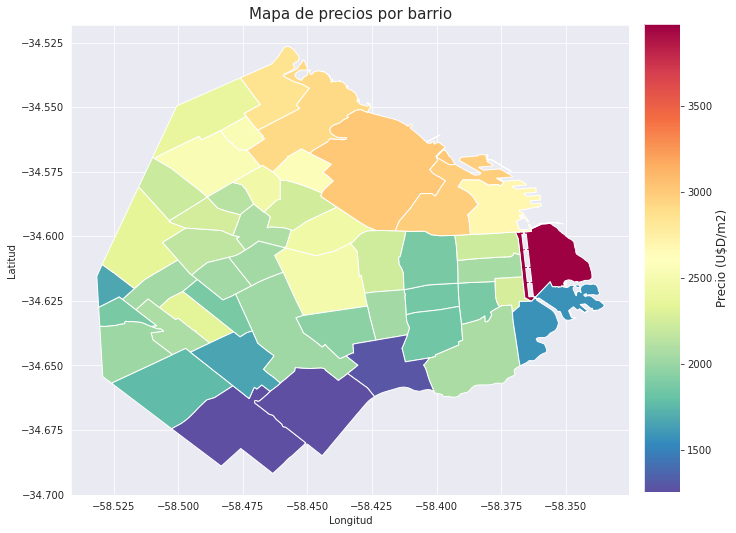

In [25]:
# Control del tamaño de la figura del mapa
fig, ax = plt.subplots(figsize=(10, 10))
 
# Control de título y ejes
ax.set_title('Mapa de precios por barrio', size=15)
ax.set_xlabel('Longitud', size=10)
ax.set_ylabel('Latitud', size=10)

# Control de la barra 
min_p = min(precioxbarrio_geo['mean'])
max_p = max(precioxbarrio_geo['mean'])
bar = plt.cm.ScalarMappable(cmap='Spectral_r', norm=plt.Normalize(vmin = min_p , vmax=max_p)) #definición
cax = plt.axes([0.92, 0.18, 0.05, 0.65]) # ubicación y tamaño [xcoord, ycoord, ancho, largo]
cbar = fig.colorbar(bar, cax=cax) # impresión
cbar.set_label('Precio (U$D/m2)', fontsize = 12) # título

# Impresión Mapa
precioxbarrio_geo.plot(column='mean', cmap='Spectral_r', ax=ax)

Como puede verse, el gradiante de precios por metro cuadrado registra una distribución con una marcada división entre el norte y sur de la ciudad, y otra, más matizada, este / oeste. 

Ello responde a que los inmuebles, al ser inseparables del terreno donde se asientan, incluyen en su precio una porción de renta del suelo urbano, que se encuentra determinada por diversos factores que hacen a la localización: la distancia respecto del centro administrativo y de negocios, el acceso a infraestructuras, servicios y equipamientos (especialmente de transporte), la edificabilidad y los usos permitidos en cada zona, etc.

En las secciones que siguen nos propusimos crear un conjunto de nuevas variables que nos permitieran introducir algunos de estos aspectos en la modelización:
* ubicación en el eje norte / sur (dummy)
* ubicación en el eje norte / sur: distancia del centro urbano (continua)
* cercanía con el subte (dummy)
* cercanía con un barrio informal (dummy)
* cercanía con una zona comercial (dummy) 


Para ello realizaremos una serie de operaciones a partir de la consulta de datasets disponibles en portales de datos oficiales, para lo cual precisaremos, antes que nada, convertir nuestro dataframe en uno espacial.



In [26]:
geo_data = gpd.GeoDataFrame(deptos_caba_clean, geometry = gpd.points_from_xy(deptos_caba_clean.x, deptos_caba_clean.y),crs=4326) 
geo_caba_inmuebles = geo_data.to_crs(crs=3857)

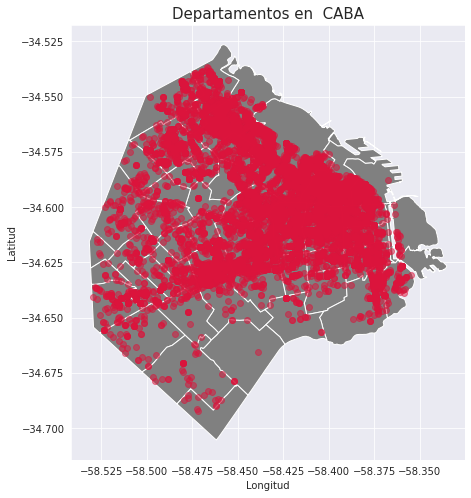

In [27]:
# Control del tamaño de la figura del mapa
fig, ax = plt.subplots(figsize=(8, 8))

# Control de título y ejes
ax.set_title('Departamentos en  CABA', size=15)
ax.set_xlabel('Longitud', size=10)
ax.set_ylabel('Latitud', size=10)

# Impresión Mapa
geo_barrios.plot(ax=ax, color='grey')
geo_data.plot(ax=ax, color='crimson', alpha=0.5)

#### Eje norte / sur

Buscamos entonces dar cuenta de las dinámicas propias en términos del gradiente de precios de los inmuebles de la ciudad a partir de la creación de variables que lograran captar el progresivo decrecimiento de éstos entre norte y sur y desde el río hacia el oeste. En cuanto al eje norte / sur, se creó una variable binaria asignando un 1 a las propiedades ubicadas en el corredor que va desde Puerto Madero hasta Nuñez y 0 a las localizadas en el resto de los barrios. Creamos también una variable binaria específica  para identificar los inmuebles ubicados Puerto Madero, ya que, como vimos en el gradiente de la ciudad, sus precios  superan ampliamente a los del segundo barrio más caro. 

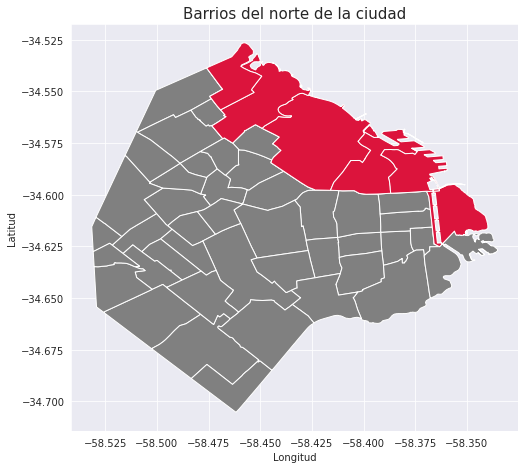

In [28]:
# Control del tamaño de la figura del mapa
fig, ax = plt.subplots(figsize=(8, 8))

# Control de título y ejes
ax.set_title('Barrios del norte de la ciudad', size=15)
ax.set_xlabel('Longitud', size=10)
ax.set_ylabel('Latitud', size=10)

# Mascata barrios norte
mask_norte = (geo_barrios['BARRIO'] == 'PUERTO MADERO') | (geo_barrios['BARRIO'] == 'RETIRO') | (geo_barrios['BARRIO'] == 'RECOLETA') | (geo_barrios['BARRIO'] == 'PALERMO') | (geo_barrios['BARRIO'] == 'BELGRANO') | (geo_barrios['BARRIO'] == 'NUÑEZ')
barrios_norte = geo_barrios[mask_norte]

# Mapa
geo_barrios.plot(ax=ax, color='grey')
geo_barrios[mask_norte].plot(ax=ax, color='crimson')

In [29]:
# Creación de variable zona norte
barrios_mapper = {'Agronomía':'0', 'Almagro':'0', 'Balvanera':'0', 'Barracas':'0', 'Belgrano':'1', 'Boca':'0', 'Boedo':'0', 'Caballito':'0', 
                  'Chacarita':'0', 'Coghlan':'0', 'Colegiales':'0', 'Constitución':'0', 'Flores':'0', 'Floresta':'0', 'Liniers':'0', 
                  'Mataderos':'0', 'Monserrat':'0', 'Monte Castro':'0', 'Nueva Pompeya':'0',  'Nuñez':'1', 'Paternal':'0',  'Palermo':'1',
                  'Parque Avellaneda':'0', 'Parque Chacabuco':'0', 'Parque Chas':'0','Parque Patricios':'0', 'Puerto Madero':'1', 
                  'Recoleta':'1', 'Retiro':'1', 'Saavedra':'0', 'San Cristobal':'0', 'San Nicolás':'0', 'San Telmo':'0', 
                  'Velez Sarsfield':'0', 'Versalles':'0', 'Villa Crespo':'0', 'Villa Devoto':'0', 'Villa Gral. Mitre':'0', 'Villa Lugano':'0', 
                  'Villa Luro':'0', 'Villa Ortuzar':'0', 'Villa del Parque':'0', 'Villa Pueyrredón':'0', 'Villa Real':'0', 
                  'Villa Santa Rita':'0', 'Villa Soldati':'0', 'Villa Urquiza':'0'}
geo_caba_inmuebles['zona_norte'] = geo_caba_inmuebles.place_name.map(barrios_mapper)
geo_caba_inmuebles['zona_norte'] = geo_caba_inmuebles['zona_norte'].astype('float64')

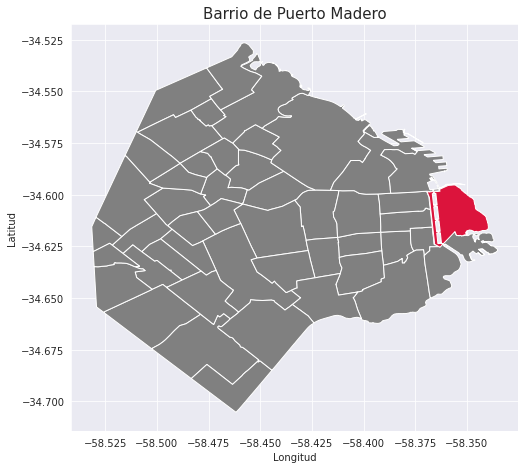

In [30]:
# Control del tamaño de la figura del mapa
fig, ax = plt.subplots(figsize=(8, 8))

# Control de título y ejes
ax.set_title('Barrio de Puerto Madero', size=15)
ax.set_xlabel('Longitud', size=10)
ax.set_ylabel('Latitud', size=10)

# Mascata Puerto Madero
mask_pto_madero = (geo_barrios['BARRIO'] == 'PUERTO MADERO')
puerto_madero = geo_barrios[mask_pto_madero]

# Mapa
geo_barrios.plot(ax=ax, color='grey')
geo_barrios[mask_pto_madero].plot(ax=ax, color='crimson')

In [31]:
madero = geo_caba_inmuebles
madero['madero'] = madero.apply(lambda x: 1 if x['place_name'] == 'Puerto Madero' else 0, axis=1)
geo_caba_inmuebles = madero

#### Eje este / oeste: distancia del centro urbano

Para el Eje Este - Oeste, se optó por medir la distancia lineal en metros desde el Congreso de la Nación hasta los inmuebles. 

In [32]:
# Creacion del Dataset con las coordenadas del Congreso de la Nacion
geo_congreso_raw = pd.DataFrame({"X" : [-58.392722],"Y" : [-34.609745], "punto" : 'Congreso'})
geo_congreso_raw.head()

,X,Y,punto
0,-58.392722,-34.609745,Congreso


In [33]:
# Creacion de Dataset espacial
geo_congreso = gpd.GeoDataFrame(geo_congreso_raw, geometry = gpd.points_from_xy(geo_congreso_raw.X, geo_congreso_raw.Y), crs=4326)
geo_congreso_3857 = geo_congreso.to_crs(crs=3857) 

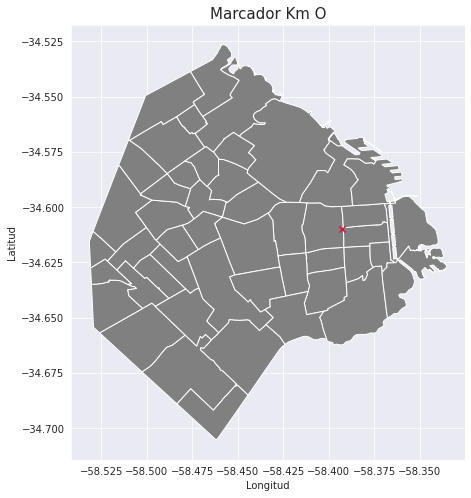

In [34]:
# Control del tamaño de la figura del mapa
fig, ax = plt.subplots(figsize=(8, 8))

# Control de título y ejes
ax.set_title('Marcador Km O', size=15)
ax.set_xlabel('Longitud', size=10)
ax.set_ylabel('Latitud', size=10)

# Mapa
geo_barrios.plot(ax=ax, color='grey')
geo_congreso.plot(ax=ax, color = 'crimson', marker = 'x')

In [35]:
# Imputacion de distancias de los inmuebles al Congreso de la Nacion
geo_dist_congreso = geo_caba_inmuebles
geo_dist_congreso['distancia'] = geo_dist_congreso.apply(lambda x: geo_congreso_3857.distance(x['geometry']), axis=1)
geo_caba_inmuebles = geo_dist_congreso 

#### Cercanía con el subte

In [36]:
# Importacion del Dataset de Bocas de Subte
data_location_2 = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/sbase/bocas-subte/bocas-de-subte.csv'
subte_data_raw = pd.read_csv(data_location_2, sep=',')

In [37]:
# Creación de Dataset espacial
geo_subte = gpd.GeoDataFrame(subte_data_raw, geometry = gpd.points_from_xy(subte_data_raw.long, subte_data_raw.lat),crs=4326)
geo_subte_3857 = geo_subte.to_crs(crs=3857)
geo_subte_clean = geo_subte_3857.loc[:,('long','lat','linea','Objeto','geometry')]

In [38]:
# Se realiza un buffer de 500 mts desde las bocas de Subte
subte_buffer_pts = geo_subte_clean
subte_buffer_pts['buffer'] = geo_subte_clean.buffer(500, cap_style=1, join_style=2, mitre_limit=5.0, single_sided=False) 
subte_buffer_pts_clean = subte_buffer_pts.loc[:,('long','lat','linea','Objeto','buffer')]
subte_buffer_clean = subte_buffer_pts_clean.rename(columns={'buffer':'geometry'})

# Se disuelven los limites para trabajar con una unica entidad
subte_buffer = subte_buffer_clean.dissolve(by='Objeto')
subte_buffer

,geometry,long,lat,linea
Objeto,,,,
Boca de subte,"MULTIPOLYGON (((-6507585.301 -4115863.758, -65...",-58.384068,-34.602106,D


(1, 4)

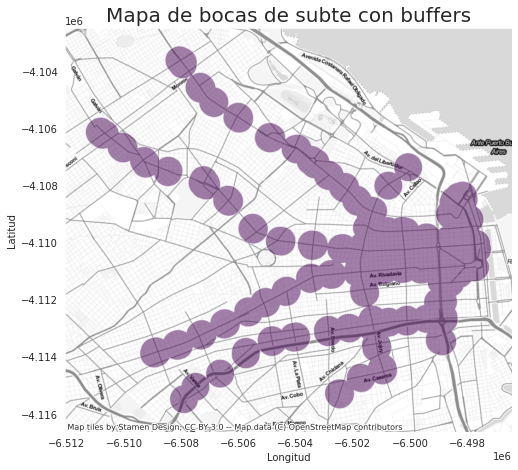

In [39]:
display(subte_buffer.shape)
display(subte_buffer.geometry.dtype)

fig, ax = plt.subplots(figsize=(8,20))
plt.grid()
subte_buffer.plot(ax=ax,
                   legend = False,
                   column='linea',
                   cmap='viridis',
                   alpha= 0.5)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
plt.title('Mapa de bocas de subte con buffers', size=20);
plt.ylabel('Latitud');
plt.xlabel('Longitud'); 
plt.show()

In [40]:
# Join con el Dataset de propiedades
prueba1 = gpd.sjoin(geo_caba_inmuebles, subte_buffer, how='left', op='intersects')

# Asignacion de categorias binarias, subte si/no
prueba1['subte'] = prueba1.apply(lambda x: 1 if x['index_right'] == 'Boca de subte' else 0, axis=1)
prueba1_clean = prueba1.drop(['index_right','long','lat','linea'],axis=1)
prueba1_clean.sample(2)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,price,currency,...,title,image_thumbnail,region,x,y,geometry,zona_norte,madero,distancia,subte
9998,9998,sell,apartment,Recoleta,|Argentina|Capital Federal|Barrio Norte|,Argentina,Ciudad Autónoma de Buenos Aires,3436109.0,170000.0,USD,...,Pacheco de Melo 2900 4º,https://thumbs4.properati.com/3/UyE5LrKPmS7Wik...,Capital Federal,-58.404545,-34.584815,POINT (-6501564.232 -4107601.261),1.0,0,3619.240942,0
119284,119284,sell,apartment,Recoleta,|Argentina|Capital Federal|Barrio Norte|,Argentina,Ciudad Autónoma de Buenos Aires,3436109.0,155100.0,USD,...,Bulnes 1900 - Barrio Norte - Mono al Frente,https://thumbs4.properati.com/8/DiSoudZaUnwB7Y...,Capital Federal,-58.412227,-34.588813,POINT (-6502419.328 -4108141.922),1.0,0,3567.585155,1


In [41]:
geo_caba_inmuebles = prueba1_clean

#### Cercanía con un barrio informal

In [42]:
# Importacion del Dataset de Barrios Populares
data_location_2 = 'https://datosabiertos.desarrollosocial.gob.ar/dataset/0d022767-9390-486a-bff4-ba53b85d730e/resource/9a951270-60dd-4f21-aa19-4ef1205620bd/download/2022-07-13_info_publica.csv'
data_raw_2 = pd.read_csv(data_location_2, sep=',')
data_raw_2 = data_raw_2.rename(columns={'geometry':'WKT'})
data_raw_2["WKT"] = data_raw_2["WKT"].apply(shapely.wkt.loads) 

In [43]:
# Creación de Dataset espacial
geo_bp = gpd.GeoDataFrame(data_raw_2, geometry='WKT')
geo_bp_caba = geo_bp.loc[(geo_bp['provincia'] == 'Ciudad Autónoma de Buenos Aires')]
geo_bp_caba = geo_bp_caba.reset_index()
geo_bp_caba = geo_bp_caba.loc[:,('id_renabap','nombre_barrio','WKT')]
geo_bp_caba.crs = "EPSG:4326"                       
geo_bp_caba_3857 = geo_bp_caba.to_crs(crs=3857) 

In [44]:
# Se realiza un buffer de 500 metros desde los limites exteriores de los Barrios Populares
bp_buffer_pts = geo_bp_caba_3857
bp_buffer_pts['buffer'] = geo_bp_caba_3857.buffer(500, cap_style=1, join_style=2, mitre_limit=5.0, single_sided=False)
bp_buffer_pts_clean = bp_buffer_pts.loc[:,('id_renabap','nombre_barrio','buffer')]
bp_buffer_clean = bp_buffer_pts_clean.rename(columns={'buffer':'geometry'})

# Se disuelven los limites para trabajar con una unica entidad
bp_buffer = bp_buffer_clean
bp_buffer['id_renabap'] = bp_buffer.apply(lambda x: 1, axis=1)
bp_buffer = bp_buffer.dissolve(by='id_renabap')
bp_buffer

,geometry,nombre_barrio
id_renabap,,
1,"MULTIPOLYGON (((-6507887.141 -4121871.678, -65...",Rodrigo Bueno


(1, 2)

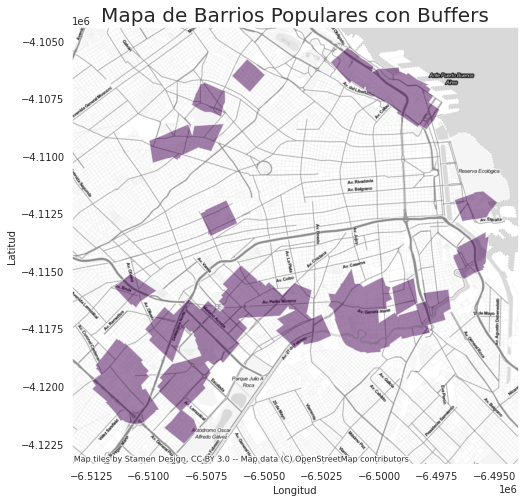

In [45]:
display(bp_buffer.shape)
display(bp_buffer.geometry.dtype)

fig, ax = plt.subplots(figsize=(8,20))
plt.grid()
bp_buffer.plot(ax=ax,
                   legend = False,
                   #column='linea',
                   cmap='viridis',
                   alpha= 0.5)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
plt.title('Mapa de Barrios Populares con Buffers', size=20);
plt.ylabel('Latitud');
plt.xlabel('Longitud'); 
plt.show()

In [46]:
# Join con el Dataset de propiedades
prueba2 = gpd.sjoin(geo_caba_inmuebles, bp_buffer, how='left', op='intersects')

# Asignacion de categorias binarias, Barrio Populares si/no
prueba2['bp'] = prueba2.apply(lambda x: 1 if x['nombre_barrio'] == 'Rodrigo Bueno' else 0, axis=1)
prueba2_clean = prueba2.drop(['index_right','nombre_barrio'],axis=1)
prueba2_clean.sample(2)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,price,currency,...,image_thumbnail,region,x,y,geometry,zona_norte,madero,distancia,subte,bp
55231,55231,sell,apartment,Barracas,|Argentina|Capital Federal|Barracas|,Argentina,Ciudad Autónoma de Buenos Aires,3436134.0,185000.0,USD,...,https://thumbs4.properati.com/7/9MMcjoFdR00wSq...,Capital Federal,-58.374915,-34.648548,POINT (-6498265.802 -4116222.158),0.0,0,5611.252741,0,0
60474,60474,sell,apartment,Recoleta,|Argentina|Capital Federal|Recoleta|,Argentina,Ciudad Autónoma de Buenos Aires,3429595.0,86000.0,USD,...,https://thumbs4.properati.com/3/Y4oHHgZ_TVl7Uk...,Capital Federal,-58.400601,-34.597469,POINT (-6501125.143 -4109312.397),1.0,0,1877.730603,1,0


In [47]:
geo_caba_inmuebles = prueba2_clean

#### Cercanía con una zona comercial

In [48]:
# Importacion del Dataset de Relevamiento de Usos del Suelo. Tener en cuenta que puede tardar unos minutos en cargar.
data_location_3 = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/secretaria-de-desarrollo-urbano/relevamiento-usos-suelo/relevamiento-usos-del-suelo-2017.csv'
relev_data_raw = pd.read_csv(data_location_3, sep=',')
relev_data_clean = relev_data_raw.loc[:,('X','Y','COMUNA','RAMA')]
relev_data_clean.shape

(561722, 4)

In [49]:
act_comerciales = relev_data_clean['RAMA'].unique()
act_comerciales

array(['EDIFICIOS',
       'FABRICACIÓN DE PRODUCTOS ELABORADOS DE METAL, EXCEPTO MAQUINARIA  Y EQUIPO',
       'SERVICIOS COMPLEMENTARIOS AL TRANSPORTE', 'UNIFICADO',
       'VENTA Y REP. DE VEHICULOS AUTOMOTORES', 'LOCAL CERRADO',
       'HOTELERIA Y GASTRONOMIA', 'COMERCIO', 'EDICION E IMPRESIÓN',
       'VIAS TREN', 'SERVICIOS DE ASOCIACIONES', 'GALPON',
       'FABRICACION DE MAQUINARIA Y APARATOS ELECTRICOS NCP', 'LOTE',
       'ELABORACION DE PRODUCTOS ALIMENTICIOS Y BEBIDAS',
       'COMERCIO POR MAYOR', 'SERVICOS SOCIALES Y DE SALUD',
       'FABRICACION DE MUEBLES Y COLCHONES, INDUSTRIAS MANUFACTURERAS',
       'ENSEÑANZA', 'ELECTRICIDAD, GAS Y AGUA', 'SERVICIO DE TRANSPORTE',
       'FABRICACION DE PRODUCTOS QUIMICOS NCP', 'OTROS SERVICIOS',
       'SERVICIOS EMPRESARIALES',
       'SERVICIO DE TRANSPORTE URBANO DE CARGA',
       'FABRICACION DE SUSTANCIAS Y PRODUCTOS QUIMICOS',
       'FABRICACION DE AUTOPARTES, PIEZAS Y ACCESORIOS PARA VEHICULOS AUTOMOTORES Y SUS MOTORES',

In [50]:
# Se van a considerar como "actividades comerciales" a todas aquellas ramas que no involucren fabricacion u otra actividad industrial
relev_data = relev_data_clean[relev_data_clean.RAMA.isin(['HOTELERIA Y GASTRONOMIA',
 'COMERCIO',
 'EDICION E IMPRESIÓN',
 'SERVICOS SOCIALES Y DE SALUD',
 'PLAZOLETA',
 'INTERMEDIACION FINANCIERA Y AUXILIARES',
 'SERVICIO DE CORREO Y TELECOMUNICACIONES',
 'SERVICIOS DE ESPARCIMIENTO, CULTURALES Y DEPORTIVOS',
 'SERVICIO DE HOTELERIA Y RESTAURANTES',
 'SERVICIOS INMOBILIARIOS',
 'SERVICIOS DE SEGUROS Y DE ADMINISTRACION DE FONDOS DE JUBILACIONES Y PENSIONES',
 'ALQUILER DE MAQUINARIA Y EQUIPO, ALQUILER DE EFECTOS PERSONALES',
 'SERVICIOS INFORMATICOS Y ACTIVIDADES CONEXAS',
 'SERVICIOS AUXILIARES A LA ACTIVIDAD FINANCIERA',
 'GALERIA',
 'COMERCIO AL POR MAYOR EN COMISION O CONSIGNACION',
 'SERVICIOS COMUNITARIOS, SOCIALES Y PERSONALES NCP',
 'SERVICIO DE TRANSPORTE AEREO',
 'SERVICIOS EMPRESARIALES NCP',
 'SERVICIOS AGRICOLAS Y PECUARIOS'])]
relev_data.shape

(84887, 4)

In [51]:
# Creación de Dataset espacial
geo_relev = gpd.GeoDataFrame(relev_data, geometry = gpd.points_from_xy(relev_data.X, relev_data.Y), crs=4326)
geo_relev = geo_relev.to_crs(crs=3857)

In [52]:
# Se realiza un buffer de 50 metros desde el punto del comercio
relev_buffer_pts = geo_relev
relev_buffer_pts['buffer'] = geo_relev.buffer(50, cap_style=1, join_style=2, mitre_limit=5.0, single_sided=False)
relev_buffer_pts_clean = relev_buffer_pts.loc[:,('X','Y','RAMA','COMUNA','buffer')]
relev_buffer_clean = relev_buffer_pts_clean.rename(columns={'buffer':'geometry'})

# Se disuelven los limites para trabajar con una unica entidad
relev_buffer = relev_buffer_clean
relev_buffer['COMUNA'] = relev_buffer.apply(lambda x: 1, axis=1)
relev_buffer = relev_buffer.dissolve(by='COMUNA')
relev_buffer

,geometry,X,Y,RAMA
COMUNA,,,,
1,"MULTIPOLYGON (((-6515167.664 -4116830.898, -65...",-58.455445,-34.597034,HOTELERIA Y GASTRONOMIA


(1, 4)

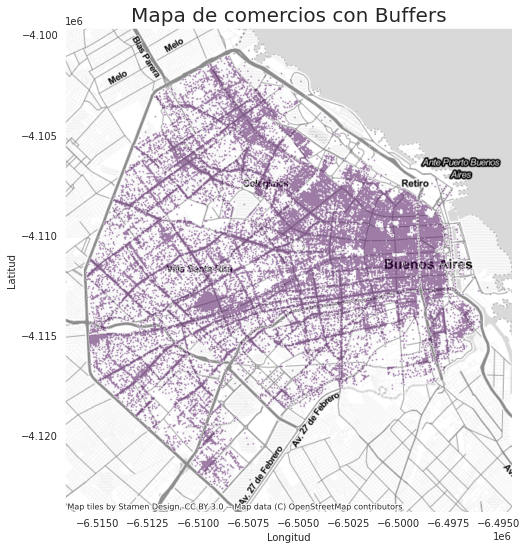

In [53]:
display(relev_buffer.shape)
display(relev_buffer.geometry.dtype)

fig, ax = plt.subplots(figsize=(8,20))
plt.grid()
relev_buffer.plot(ax=ax,
                   legend = False,
                   #column='linea',
                   cmap='viridis',
                   alpha= 0.5)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
plt.title('Mapa de comercios con Buffers', size=20);
plt.ylabel('Latitud');
plt.xlabel('Longitud'); 
plt.show()

In [54]:
# Join con el Dataset de propiedades
prueba_a = gpd.sjoin(geo_caba_inmuebles, relev_buffer, how='left', op='intersects')

# Asignacion de categorias binarias, comercio si/no
prueba_a['comercio'] = prueba_a.apply(lambda x: 1 if x['RAMA'] == 'HOTELERIA Y GASTRONOMIA' else 0, axis=1)
prueba_a_clean = prueba_a.drop(['index_right','X','Y','RAMA'],axis=1)
prueba_a_clean.sample(2)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,price,currency,...,region,x,y,geometry,zona_norte,madero,distancia,subte,bp,comercio
35707,35707,sell,apartment,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Ciudad Autónoma de Buenos Aires,3431333.0,120000.0,USD,...,Capital Federal,-58.525676,-34.648626,POINT (-6515048.451 -4116232.753),0.0,0,15707.293998,0,0,1
93178,93178,sell,apartment,Villa Crespo,|Argentina|Capital Federal|Villa Crespo|,Argentina,Ciudad Autónoma de Buenos Aires,3427458.0,107895.0,USD,...,Capital Federal,-58.426513,-34.597985,POINT (-6504009.672 -4109382.247),0.0,0,4084.010843,0,0,1


In [55]:
# Dataset final post imputación de nuevas variables de localización
geo_deptos_caba = prueba_a_clean

# Reseteamos index para las concatenaciones posteriores
geo_deptos_caba = geo_deptos_caba.reset_index()
geo_deptos_caba = geo_deptos_caba.drop(['index'], axis=1)

### Variables relativas a las características de los inmuebles 

#### Departamentos con amenities

Utilizamos regex para obtener las amenities de las propiedades. Damos por sentado que no hay casos (o suponemos que seria una cantidad irrelevante) de departamentos que cuenten con amenities y no esten declaradas.

In [56]:
# Regex amenities
amenities_pattern = re.compile('amenities|ammenities|pileta|sum|gimnasio|gim|gym|solarium|parrilla|parrillas|cochera|cocheras|lavanderia|lavandería|seguridad|terraza|jardín|jardin', flags = re.IGNORECASE )
# Realiza el search en la columna y lo guarda en una serie
amenities_search = geo_deptos_caba['description'].apply(lambda x : x if x is np.NaN else amenities_pattern.search(x))
# Vuelca los datos en nueva columna dentro del data frame
geo_deptos_caba['amenities'] = amenities_search.apply(lambda x: 0 if x == None else 1)


In [57]:
geo_deptos_caba['amenities'].value_counts()

1    6608
0    4250
Name: amenities, dtype: int64

#### Departamentos a estrenar

In [58]:
# Regex a estrenar
estrenar_pattern =  re.compile("estrenar", flags = re.IGNORECASE ) 
estrenar_search = geo_deptos_caba['description'].apply(lambda x : x if x is np.NaN else estrenar_pattern.search(x))
# Vuelca los datos en una nueva columna dentro del data frame y asigna categorias binarias, a estrenar si/no
geo_deptos_caba['a_estrenar'] = estrenar_search.apply(lambda x: 0 if x == None else 1) 

In [59]:
deptos_caba_final = geo_deptos_caba

### Eliminación de variables que no se van a utilizar

En este apartado nos deshicimos de todas aquellas variables (columnas) que no utilizaremos en el proceso de modelización.

In [60]:
deptos_caba_final = deptos_caba_final.drop(deptos_caba_final.iloc[:, 0:12], axis=1)
deptos_caba_final = deptos_caba_final.drop(deptos_caba_final.iloc[:, 6:12], axis=1)
deptos_caba_final = deptos_caba_final.drop(['price_per_m2','floor','geometry','x','y'], axis= 1)
deptos_caba_final.columns

Index(['surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'rooms', 'zona_norte', 'madero', 'distancia', 'subte', 'bp', 'comercio',
       'amenities', 'a_estrenar'],
      dtype='object')

Llegamos así a un conjunto de variables predictoras o ***features*** compuesto por 5 variables de localización (ubicación en barrios del eje norte, distancia del centro, cercanía con el subte, cercanía con una zona comercial y cercanía con un barrio informal) y 5 variables referidas a características de las propiedades independientemente de su ubicación (superficie total y cubierta, cantidad de ambientes, la existencia o no de amenities -desagregada por tipo- y el carácter a estrenar o no de las propiedades). A partir de la modelización del conjunto de datos organizado en torno a estas variables buscaremos predecir nuestra variable ***target***: el precio en dólares por metro cuadrado.


# MODELIZACIÓN

## Regresion Lineal Simple

Para realizar el proceso de modelización, comenzamos por generar regresiones lineales simples para cada una de nuestras variables predictivas (FEATURES) con el fin de analizar su correlación con la variable a predecir (TARGET)

### Variables de localizacion

Como hemos mencionado, las variables de localización construidas en base a las coordenadas del dataset original pueden no corresponer necesariamente al punto donde se encuentra el inmueble publicado, ya que desconocemos la manera en que se han establecido y es posible que hayan sido generadas de manera automática por la ubicación del dispositivo desde el cual se realizó la carga. Las variables creadas en base a un buffer de una zona de cobertura o influencia resultarán especialmente sensibles a estas inconsistencias. En cambio se estimó que la variable construida en base al barrio de ubicación de los inmuebles no debería revestir el mismo problema.  

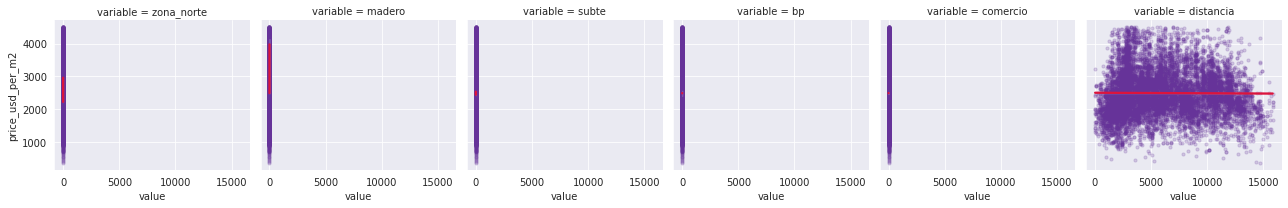

In [61]:
deptos_caba_final_grid_1 = pd.melt(deptos_caba_final, id_vars="price_usd_per_m2", value_vars = ["zona_norte", "madero", "subte", "bp", "comercio", "distancia"])
a = sns.FacetGrid(deptos_caba_final_grid_1, col="variable")
a.map(sns.regplot, "value", "price_usd_per_m2",  
      ci = 95,
      scatter_kws = {"color": "rebeccapurple", 's': 10, 'alpha':0.2}, 
      line_kws = {"color": "crimson"});

In [62]:
# Modelo lineal simple sobre variable 'zona_norte'

X_t = np.array(deptos_caba_final.zona_norte, ndmin=2)
X = np.transpose(X_t)
y = deptos_caba_final.price_usd_per_m2

# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     4032.
Date:                Mon, 07 Nov 2022   Prob (F-statistic):               0.00
Time:                        03:52:23   Log-Likelihood:                -84536.
No. Observations:               10858   AIC:                         1.691e+05
Df Residuals:                   10856   BIC:                         1.691e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2226.8265      7.014    317.498      0.0

In [63]:
# Modelo lineal simple sobre variable 'madero'

X_t = np.array(deptos_caba_final.madero, ndmin=2)
X = np.transpose(X_t)
y = deptos_caba_final.price_usd_per_m2

# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     105.2
Date:                Mon, 07 Nov 2022   Prob (F-statistic):           1.45e-24
Time:                        03:52:23   Log-Likelihood:                -86199.
No. Observations:               10858   AIC:                         1.724e+05
Df Residuals:                   10856   BIC:                         1.724e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2493.0520      6.518    382.488      0.0

In [64]:
# Modelo lineal simple sobre variable 'subte'

X_t = np.array(deptos_caba_final.subte, ndmin=2)
X = np.transpose(X_t)
y = deptos_caba_final.price_usd_per_m2

# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     53.28
Date:                Mon, 07 Nov 2022   Prob (F-statistic):           3.10e-13
Time:                        03:52:23   Log-Likelihood:                -86224.
No. Observations:               10858   AIC:                         1.725e+05
Df Residuals:                   10856   BIC:                         1.725e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2538.3878      8.731    290.738      0.0

In [65]:
# Modelo lineal simple sobre variable 'bp'

X_t = np.array(deptos_caba_final.bp, ndmin=2)
X = np.transpose(X_t)
y = deptos_caba_final.price_usd_per_m2

# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.04888
Date:                Mon, 07 Nov 2022   Prob (F-statistic):              0.825
Time:                        03:52:23   Log-Likelihood:                -86251.
No. Observations:               10858   AIC:                         1.725e+05
Df Residuals:                   10856   BIC:                         1.725e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2496.3245      6.651    375.354      0.0

In [66]:
# Modelo lineal simple sobre variable 'comercio'

X_t = np.array(deptos_caba_final.comercio, ndmin=2)
X = np.transpose(X_t)
y = deptos_caba_final.price_usd_per_m2

# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.04357
Date:                Mon, 07 Nov 2022   Prob (F-statistic):              0.835
Time:                        03:52:23   Log-Likelihood:                -86251.
No. Observations:               10858   AIC:                         1.725e+05
Df Residuals:                   10856   BIC:                         1.725e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2492.7794     17.028    146.389      0.0

In [67]:
# Modelo lineal simple sobre variable 'distancia'

X_t = np.array(deptos_caba_final.distancia, ndmin=2)
X = np.transpose(X_t)
y = deptos_caba_final.price_usd_per_m2

# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7819
Date:                Mon, 07 Nov 2022   Prob (F-statistic):              0.377
Time:                        03:52:23   Log-Likelihood:                -86251.
No. Observations:               10858   AIC:                         1.725e+05
Df Residuals:                   10856   BIC:                         1.725e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2505.7603     12.772    196.189      0.0

El análisis de los resultados que surgen de los resúmenes estadísticos arrojados por los modelos de regresión lineal simple sobre las variables de localización da cuenta de que, efectivamente, la única variable que se correlaciona de manera más evidente con el precio por metro cuadrado es la de ubicación en barrios del corredor norte.
Entendemos que ello responde a las inconsistencias mencionadas en la localización por coordenadas. 

### Variables relativas a las caracteristicas de los inmuebles

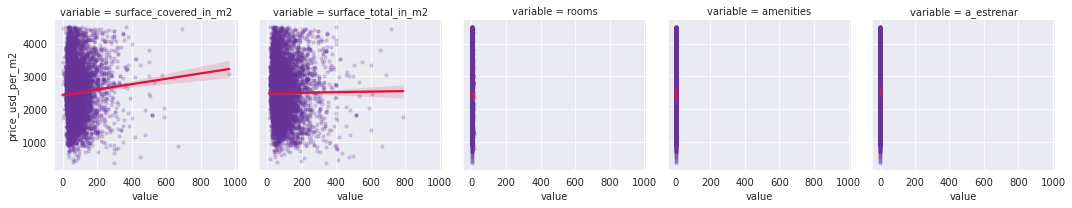

In [68]:
deptos_caba_final_grid_2 = pd.melt(deptos_caba_final, id_vars="price_usd_per_m2", value_vars = ['surface_covered_in_m2','surface_total_in_m2',
                                                                                                'rooms', 'amenities', 'a_estrenar'])
b = sns.FacetGrid(deptos_caba_final_grid_2, col="variable")
b.map(sns.regplot, "value", "price_usd_per_m2",  
      ci = 95,
      scatter_kws = {"color": "rebeccapurple", 's': 10, 'alpha':0.2}, 
      line_kws = {"color": "crimson"});

In [69]:
# Modelo lineal simple sobre variable 'superficie cubierta en metros cuadrados'

X_t = np.array(deptos_caba_final.surface_covered_in_m2, ndmin=2)
X = np.transpose(X_t)
y = deptos_caba_final.price_usd_per_m2

# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     44.26
Date:                Mon, 07 Nov 2022   Prob (F-statistic):           3.02e-11
Time:                        03:52:30   Log-Likelihood:                -86229.
No. Observations:               10858   AIC:                         1.725e+05
Df Residuals:                   10856   BIC:                         1.725e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2440.0537     10.654    229.024      0.0

In [70]:
# Modelo lineal simple sobre variable 'superficie total en metros cuadrados'

X_t = np.array(deptos_caba_final.surface_total_in_m2, ndmin=2)
X = np.transpose(X_t)
y = deptos_caba_final.price_usd_per_m2

# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5736
Date:                Mon, 07 Nov 2022   Prob (F-statistic):              0.449
Time:                        03:52:30   Log-Likelihood:                -86251.
No. Observations:               10858   AIC:                         1.725e+05
Df Residuals:                   10856   BIC:                         1.725e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2489.6062     10.745    231.709      0.0

In [71]:
# Modelo lineal simple sobre variable 'rooms'

X_t = np.array(deptos_caba_final.rooms, ndmin=2)
X = np.transpose(X_t)
y = deptos_caba_final.price_usd_per_m2

# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.713
Date:                Mon, 07 Nov 2022   Prob (F-statistic):             0.0300
Time:                        03:52:30   Log-Likelihood:                -86249.
No. Observations:               10858   AIC:                         1.725e+05
Df Residuals:                   10856   BIC:                         1.725e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2522.7435     13.923    181.194      0.0

In [72]:
# Modelo lineal simple sobre variable 'amenities'

X_t = np.array(deptos_caba_final.amenities, ndmin=2)
X = np.transpose(X_t)
y = deptos_caba_final.price_usd_per_m2

# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     550.0
Date:                Mon, 07 Nov 2022   Prob (F-statistic):          1.09e-118
Time:                        03:52:30   Log-Likelihood:                -85983.
No. Observations:               10858   AIC:                         1.720e+05
Df Residuals:                   10856   BIC:                         1.720e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2309.3980     10.203    226.351      0.0

In [73]:
# Modelo lineal simple sobre variable 'a_estrenar'

X_t = np.array(deptos_caba_final.a_estrenar, ndmin=2)
X = np.transpose(X_t)
y = deptos_caba_final.price_usd_per_m2

# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     56.65
Date:                Mon, 07 Nov 2022   Prob (F-statistic):           5.61e-14
Time:                        03:52:30   Log-Likelihood:                -86223.
No. Observations:               10858   AIC:                         1.724e+05
Df Residuals:                   10856   BIC:                         1.725e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2478.9503      6.910    358.725      0.0

El análisis de los resultados que surgen de los resúmenes estadísticos arrojados por los modelos de regresión lineal simple sobre las variables relativas a las caracterísiticas propias de los inmuebles con independencia de su localización da cuenta de que las mayores correlaciones con la variable a predecir correponden a la presencia de amenities, el carácter a estrenar de las propiedades y la superficie cubierta (más específicamente, la proporción entre superficie cubierta y superficie total, si miramos las métricas arrojadas por el modelo en base a esta última).   

## Normalización

In [74]:
# Normalizacion de los datos
initial_nums = ['surface_total_in_m2', 'surface_covered_in_m2', 'distancia']
X = deptos_caba_final[initial_nums]
scaler = StandardScaler(with_mean=False)
scaler.fit(X)
std_nums = scaler.transform(X)
std_nums_df = pd.DataFrame(std_nums, columns= [i + '_std' for i in initial_nums])
std_nums_df

,surface_total_in_m2_std,surface_covered_in_m2_std,distancia_std
0,0.921382,1.034361,4.265339
1,0.753858,0.752262,2.403202
2,1.742250,1.805430,1.152942
3,1.976784,1.372879,0.903715
4,0.720353,0.808682,2.644895
...,...,...,...
10853,0.485820,0.451357,0.503385
10854,1.893021,2.125141,0.721935
10855,1.524469,1.222426,0.490503
10856,0.737106,0.733456,0.837355


In [75]:
# Concatena ambos data frames
deptos_caba_final2 = pd.concat([deptos_caba_final, std_nums_df], axis= 1 )
deptos_caba_final2 = deptos_caba_final2.drop(['surface_total_in_m2','surface_covered_in_m2','distancia'], axis=1)
deptos_caba_final2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10858 entries, 0 to 10857
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   price_usd_per_m2           10858 non-null  float64
 1   rooms                      10858 non-null  float64
 2   zona_norte                 10858 non-null  float64
 3   madero                     10858 non-null  int64  
 4   subte                      10858 non-null  int64  
 5   bp                         10858 non-null  int64  
 6   comercio                   10858 non-null  int64  
 7   amenities                  10858 non-null  int64  
 8   a_estrenar                 10858 non-null  int64  
 9   surface_total_in_m2_std    10858 non-null  float64
 10  surface_covered_in_m2_std  10858 non-null  float64
 11  distancia_std              10858 non-null  float64
dtypes: float64(6), int64(6)
memory usage: 1018.1 KB


In [76]:
deptos_caba_final = deptos_caba_final2

##X, y, Train, test slplit

In [77]:
data_test = deptos_caba_final
# Variables feauters
X = data_test.drop(columns= ['price_usd_per_m2'])
X = sm.add_constant(X)
# Variable target
y = data_test['price_usd_per_m2']
# Divide datos de entrenamiento y datos de testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 1,shuffle=True)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## Regresión Lineal Múltiple y regularización

### Regresión Lineal Múltiple

In [78]:
# Creamos el modelo y fiteamos
lm = LinearRegression()
model_lm = lm.fit(X_train,y_train)

In [79]:
# Imprimimos los resultados del modelo
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     412.7
Date:                Mon, 07 Nov 2022   Prob (F-statistic):               0.00
Time:                        03:52:30   Log-Likelihood:                -62882.
No. Observations:                8143   AIC:                         1.258e+05
Df Residuals:                    8131   BIC:                         1.259e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [80]:
# Estimación de y
y_pred = model_lm.predict(X_train)
# Cálculo de Residuos
residuo = np.absolute(pd.Series(data = y_pred, index = y_train.index) - y_train)
print ('Cálculo de los residuos\n', residuo.sort_values(ascending= False), '\n', sep='')
# Métricas de evaluación
print ('Evaluación de la performance del modelo')
print ('MAE:', metrics.mean_absolute_error(y_train, y_pred), '\n',
       'MSE:', metrics.mean_squared_error(y_train, y_pred), '\n',
       'RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred)), sep='')

Cálculo de los residuos
4785     4306.981206
2529     2454.076684
10224    2341.437288
9834     2328.773458
9835     2320.766071
            ...     
2664        0.397377
8702        0.333851
10068       0.273713
8683        0.258922
9980        0.220253
Length: 8143, dtype: float64

Evaluación de la performance del modelo
MAE:422.4661936520004
MSE:298510.67779865145
RMSE:546.3613070108931


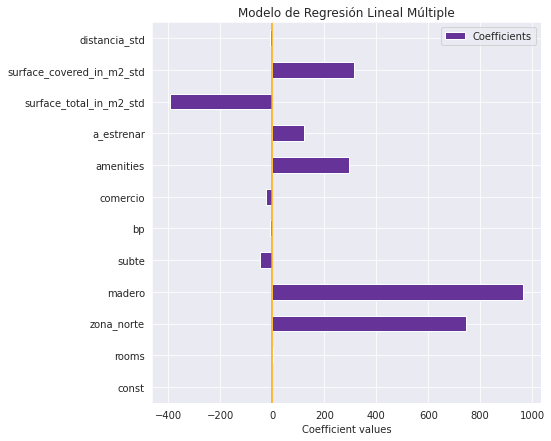

In [81]:
features = X.columns
coefs =  pd.DataFrame(model_lm.coef_, columns=["Coefficients"], index = features)
coefs.plot.barh(figsize=(9, 7), color = 'rebeccapurple')
plt.title("Modelo de Regresión Lineal Múltiple")
plt.axvline(x=0, color="orange")
plt.xlabel("Coefficient values")
plt.subplots_adjust(left=0.3)

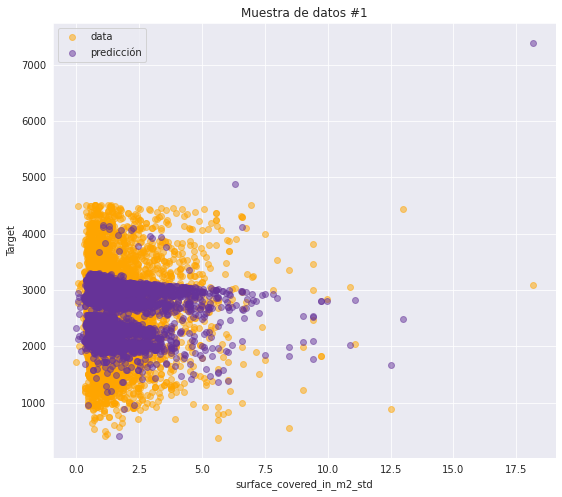

In [108]:
f, ax = plt.subplots(figsize=(9, 8))
plt.scatter(X_train.surface_covered_in_m2_std, y_train, c='orange', alpha=0.5, label="data")
plt.title("Muestra de datos #1")
plt.scatter(X_train.surface_covered_in_m2_std, y_pred, c='rebeccapurple', alpha=0.5, label="predicción")
plt.xlabel("surface_covered_in_m2_std")
plt.ylabel("Target")
plt.legend()
plt.show()


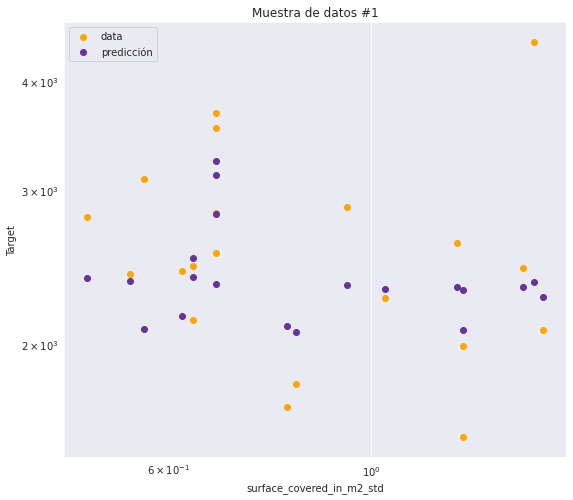

In [109]:
X1= X_train.surface_covered_in_m2_std.iloc[:20] 
Y1 = y_train.iloc[:20]
Yp = pd.DataFrame(y_pred)
Yp2 =Yp.iloc[:20]
f, ax = plt.subplots(figsize=(9, 8))
plt.scatter(X1, Y1, c="orange", label="data")
plt.title("Muestra de datos #1")
plt.scatter(X1, Yp2, c='rebeccapurple', label="predicción")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("surface_covered_in_m2_std")
plt.ylabel("Target")
plt.legend()
plt.show()

In [84]:
# Validación cruzada
cv = KFold(5, shuffle= True )
cv_scores = cross_val_score(lm, X_train, y_train, cv=cv, scoring='r2')

In [85]:
print('Score train:', model_lm.score(X_train,y_train))
print('Score test:', model_lm.score(X_test,y_test))
print(f'Score cv: {cv_scores.mean()}')

Score train: 0.3582684792229972
Score test: 0.3624012537633181
Score cv: 0.34818122542900404


### Regresión Ridge

In [86]:
# Elección del mejor valor para el hiperparámetro lambda (o alpha)
model_ridge_cv = linear_model.RidgeCV(fit_intercept= True, cv = 10)
model_ridge_cv_fit = model_ridge_cv.fit(X_train, y_train)
best_alpha = model_ridge_cv_fit.alpha_

# Reentrenamiento del modelo con el valor elegido 
model_ridge  = linear_model.Ridge(alpha = best_alpha, fit_intercept= True )
model_ridge_fit = model_ridge.fit(X_train, y_train)
print('Intercept:', model_ridge_fit.intercept_)
print('Coef:', model_ridge_fit.coef_)
print('Score train:', model_ridge_fit.score(X_train, y_train))
print('Score test:', model_ridge_fit.score(X_test,y_test))

Intercept: 2182.250418182723
Coef: [   0.            1.50180271  745.87202695  910.77062089  -48.85003314
   -9.56325756  -25.62177144  295.50690148  120.75867988 -394.58942572
  314.83222269   -7.50437221]
Score train: 0.35825520694741897
Score test: 0.3623125518112109


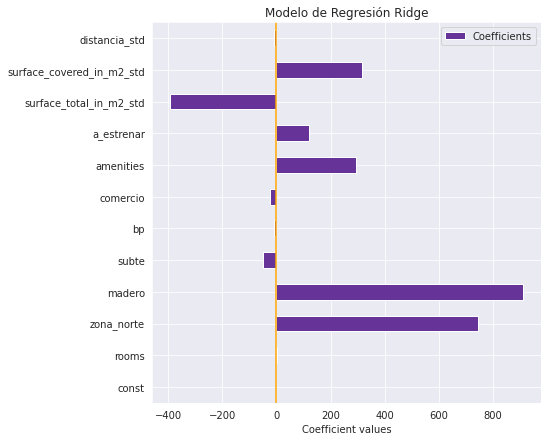

In [87]:
coefs =  pd.DataFrame(model_ridge_fit.coef_, columns=["Coefficients"], index = features)
coefs.plot.barh(figsize=(9, 7), color='rebeccapurple')
plt.title("Modelo de Regresión Ridge")
plt.axvline(x=0, color="orange")
plt.xlabel("Coefficient values")
plt.subplots_adjust(left=0.3)

In [88]:
predictions1 = model_ridge_cv_fit.predict(X_train)
y_pred1 = predictions1

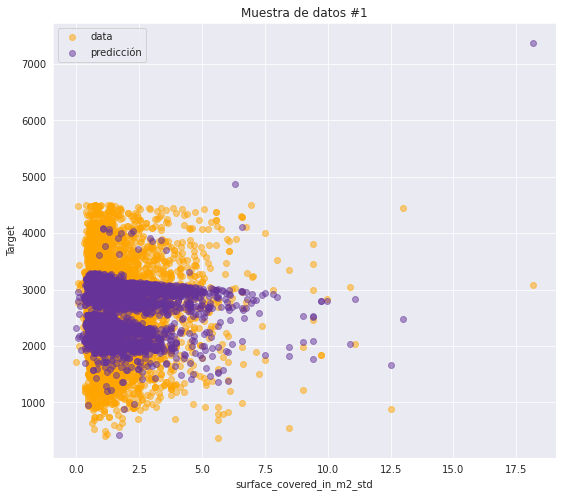

In [112]:
f, ax = plt.subplots(figsize=(9, 8))
plt.scatter(X_train.surface_covered_in_m2_std, y_train, c="orange", alpha = 0.5, label="data")
plt.title("Muestra de datos #1")
plt.scatter(X_train.surface_covered_in_m2_std, y_pred1, c='rebeccapurple', alpha = 0.5, label="predicción")
plt.xlabel("surface_covered_in_m2_std")
plt.ylabel("Target")
plt.legend()
plt.show()

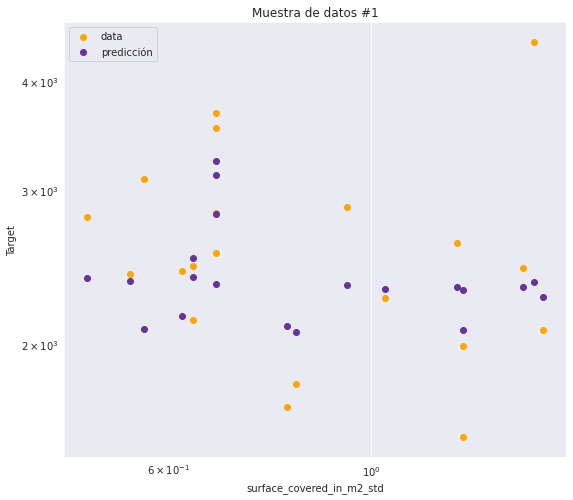

In [113]:
X1= X_train.surface_covered_in_m2_std.iloc[:20] 
Y1 = y_train.iloc[:20]
Yp = pd.DataFrame(y_pred1)
Yp2 =Yp.iloc[:20]
f, ax = plt.subplots(figsize=(9, 8))
plt.scatter(X1, Y1, c="orange", label="data")
plt.title("Muestra de datos #1")
plt.scatter(X1, Yp2, c='rebeccapurple', label="predicción")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("surface_covered_in_m2_std")
plt.ylabel("Target")
plt.legend()
plt.show()

### Regresión Lasso

In [91]:
# Elección del mejor valor para el hiperparámetro lambda (o alpha)
model_lasso_cv = linear_model.LassoCV(fit_intercept= True, cv = 10)
model_lasso_cv_fit = model_lasso_cv.fit(X_train, y_train)
best_alpha = model_lasso_cv_fit.alpha_

# Reentrenamiento del modelo con el valor elegido 
model_lasso  = linear_model.Lasso(alpha = best_alpha, fit_intercept= True )
model_lasso_fit = model_lasso.fit(X_train, y_train)
print('Intercept:', model_lasso_fit.intercept_)
print('Coef:', model_lasso_fit.coef_)
print('Score train:', model_lasso_fit.score(X_train, y_train))
print('Score test:', model_lasso_fit.score(X_test,y_test))

Intercept: 2181.393443124257
Coef: [ 0.00000000e+00  4.94974752e-01  7.45148708e+02  7.76701757e+02
 -4.77468069e+01 -0.00000000e+00 -2.36670808e+01  2.93833145e+02
  1.16309589e+02 -3.87627518e+02  3.09352609e+02 -6.88264857e+00]
Score train: 0.35808096599455597
Score test: 0.3620470504678983


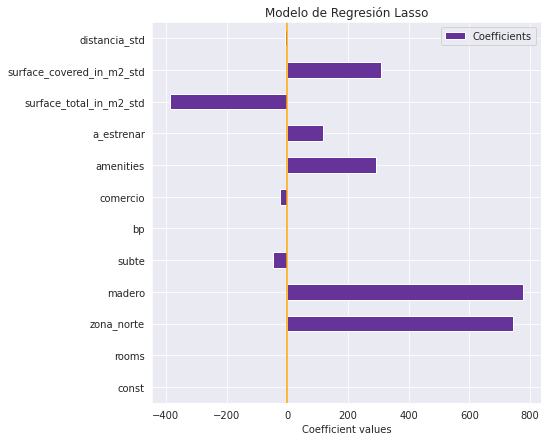

In [92]:
coefs =  pd.DataFrame(model_lasso_fit.coef_, columns=["Coefficients"], index = features)
coefs.plot.barh(figsize=(9, 7), color='rebeccapurple')
plt.title("Modelo de Regresión Lasso")
plt.axvline(x=0, color="orange")
plt.xlabel("Coefficient values")
plt.subplots_adjust(left=0.3)

In [93]:
predictions2 = model_lasso_cv_fit.predict(X_train)
y_pred2 = predictions2

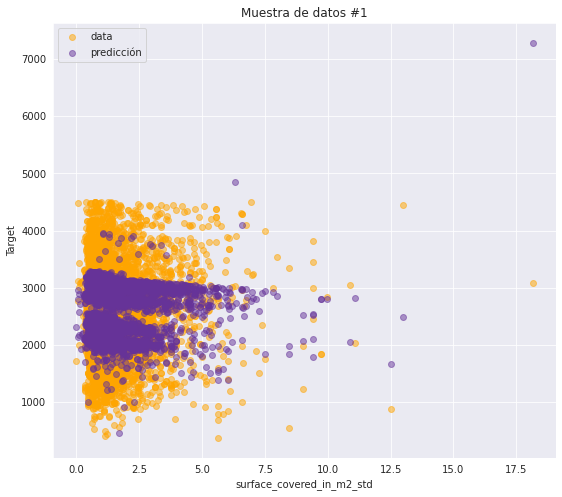

In [114]:
f, ax = plt.subplots(figsize=(9, 8))
plt.scatter(X_train.surface_covered_in_m2_std, y_train, c="orange", alpha = 0.5, label="data")
plt.title("Muestra de datos #1")
plt.scatter(X_train.surface_covered_in_m2_std, y_pred2, c='rebeccapurple', alpha = 0.5, label="predicción")
plt.xlabel("surface_covered_in_m2_std")
plt.ylabel("Target")
plt.legend()
plt.show()

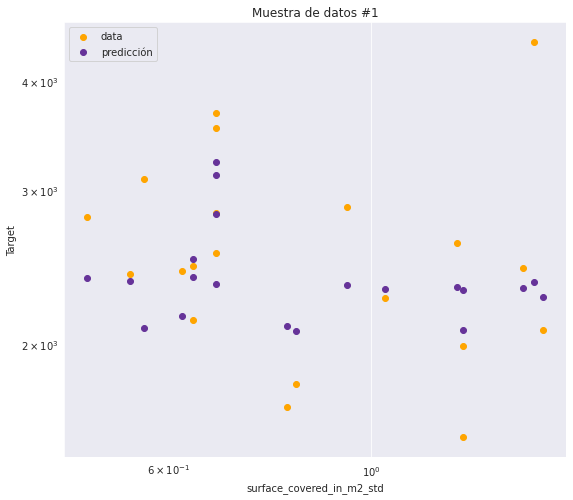

In [115]:
X1= X_train.surface_covered_in_m2_std.iloc[:20] 
Y1 = y_train.iloc[:20]
Yp = pd.DataFrame(y_pred2)
Yp2 =Yp.iloc[:20]
f, ax = plt.subplots(figsize=(9, 8))
plt.scatter(X1, Y1, c="orange", label="data")
plt.title("Muestra de datos #1")
plt.scatter(X1, Yp2, c='rebeccapurple', label="predicción")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("surface_covered_in_m2_std")
plt.ylabel("Target")
plt.legend()
plt.show()

# CONCLUSIONES FINALES

In [96]:
print ('Comparación de scores de los modelos')
print ('\nRegresión Lineal Múltiple:')
print (f'Score (R^2) en train del modelo es {model_lm.score(X_train, y_train)} y en test {model_lm.score(X_test, y_test)}')
print ('\nRegresión Lidge:')
print (f'Score (R^2) en train del modelo es {model_ridge_fit.score(X_train, y_train)} y en test {model_ridge_fit.score(X_test, y_test)}')
print ('\nRegresión Lasso:')
print (f'Score (R^2) en train del modelo es {model_lasso_fit.score(X_train, y_train)} y en test es {model_lasso_fit.score(X_test, y_test)}')


Comparación de scores de los modelos

Regresión Lineal Múltiple:
Score (R^2) en train del modelo es 0.3582684792229972 y en test 0.3624012537633181

Regresión Lidge:
Score (R^2) en train del modelo es 0.35825520694741897 y en test 0.3623125518112109

Regresión Lasso:
Score (R^2) en train del modelo es 0.35808096599455597 y en test es 0.3620470504678983


Para poder modelar la dinámica de precios de de los departamentos a la venta en la Ciudad Autónoma de Buenos Aires publicados en Properati fue necesario continuar con el proceso de limpieza y transformación del dataset original que habíamos iniciado en el trabajo práctico anterior con el fin de adecuarlo a los requerimientos de los modelos predictivos a desarrollar.

Estas transformaciones incluyeron la necesidad de generar nuevas variables asociadas a las localizaciones y a las características intrínsecas de los inmuebles considerados. Para las del primer tipo, nos apoyamos en el análisis de la distribución espacial de los precios de las propiedades, creando variables que buscaron captar los efectos de la ubicación en ellos. En este sentido, incluimos en nuestro modelo la distancia al centro administrativo y de negocios, la cobertura del subte como medio de transporte fundamental, la cercanía a zonas comerciales y de informalidad urbana, así como la ubicación en el eje Puerto Madero - Nuñez. Como hemos visto, las variables predictivas de localización más relevantes para la modelización resultaron ser estas últimas, mientras que las basadas en la intersección de las coordenadas de ubicación de los inmuebles y los buffers (zonas de cobertura o influencia) realizados sobre las bocas de subte, los barrios informales y los comercios de cercanía no aportaron capacidad predictiva al modelo. Ello puede responder al hecho de que es posible que la ubicación por coordenadas no refleje correctamente la localización de los inmuebles sino la de los dispositivos desde los cuales se realizaron las publicaciones.  

Respecto del segundo tipo de variables, sumamos a las variables ya incluidas en el dataset original provisto (superficie y cantidad de ambientes) la antigüedad de los inmuebles y la existencia de amenities, que evidenciaron una mayor correlación que aquellas con la variable a predecir. 

La incorporación de estas variables partió de algunos supuestos intuitivos y otros basados en conocimientos rudimentarios sobre el tema, cuya verificación es motivo del trabajo. 

Las técnicas de regularización agregan una "penalidad" a las funciones a través de un vector que corresponde a los parámetros del modelo (en una regresión lineal, los betas) y el alpha es un parámetro que “regula” la fuerza de la penalización: cuanto más grande es, mayor es la penalización. De esta manera, las variables con mayor variación respecto al modelo inicial son las que menor capacidad de predicción tenían y sus valores disminuyeron de manera de que tienden a cero en Lasso. Como puede apreciarse en el gráfico que se muestra en esta diapositiva, las principales variables penalizadas fueron 'ambientes y 'barrios populares”. Los modelos desarrollados arrojaron resultados que dan cuenta de que es necesario continuar ajustándolos. En este punto, se observa la necesidad realizar más pruebas para entender las características que mejor se correlacionan con el comportamiento de los precios de los inmuebles de la ciudad, así como de mejorar las variables utilizadas o incorporar otras.  